In [ ]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from IPython.display import Image, display

data_dir = '/Users/cedric/Desktop/llm_marl/results/final_eval'
csv_files = glob.glob(os.path.join(data_dir, 'final_test_*.csv'))
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {data_dir}")

stats = []
for path in csv_files:
    model_name = os.path.splitext(os.path.basename(path))[0].replace('final_test_', '')
    df = pd.read_csv(path)
    df['response_length'] = df['response'].fillna('').astype(str).str.split().apply(len)
    stats.append({
        'Model': model_name,
        'Mean':    df['response_length'].mean(),
        'Median':  df['response_length'].median(),
        'Min':     df['response_length'].min(),
        'Max':     df['response_length'].max(),
        'Std Dev': df['response_length'].std()
    })

summary_df = pd.DataFrame(stats).sort_values('Model').round(2)

fig, ax = plt.subplots(figsize=(8, 0.5 * len(summary_df) + 1))
fig.subplots_adjust(top=0.93)
ax.set_title('Response Length Comparison Across Models',
             fontsize=14, fontweight='bold',
             pad=1)
ax.axis('off')

tbl = ax.table(cellText=summary_df.values,
               colLabels=summary_df.columns,
               loc='center')

for (row, col), cell in tbl.get_celld().items():
    cell.set_text_props(ha='center', va='center')
    if row == 0:
        cell.get_text().set_fontweight('bold')

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.3)

output_path = 'response_length_comparison.png'
plt.savefig(output_path, bbox_inches='tight', dpi=300)
plt.close(fig)

display(Image(output_path))
print(f"Saved table image to: {output_path}")


FileNotFoundError: No CSV files found.

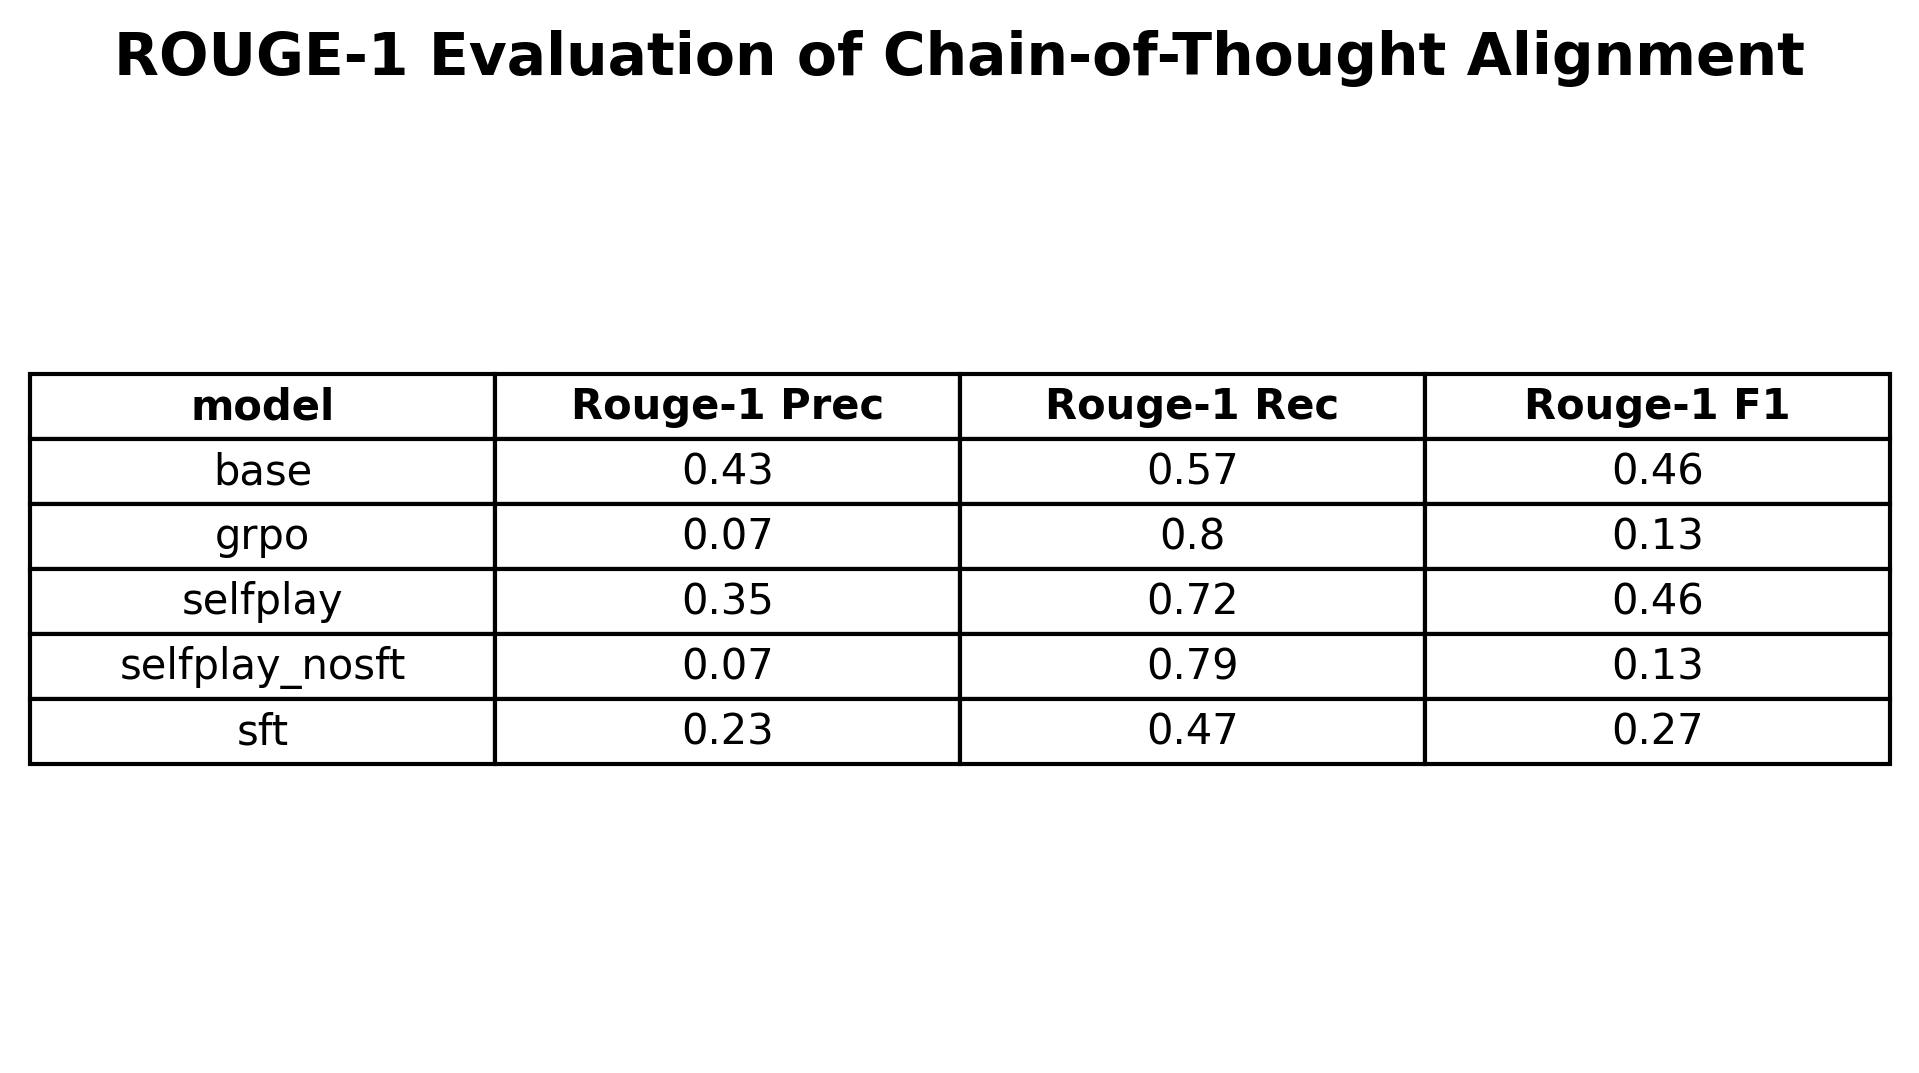

Saved table image to: rouge1_metrics.png


In [20]:
import pandas as pd
import glob
import os
import re
import matplotlib.pyplot as plt
from IPython.display import Image, display

csv_files = glob.glob('final_test_*.csv')
if not csv_files:
    raise FileNotFoundError("No CSV files found.")
df = pd.concat([
    pd.read_csv(f).assign(model=os.path.basename(f)
                                 .replace('final_test_','')
                                 .replace('.csv',''))
    for f in csv_files
], ignore_index=True)

# Define ROUGE-1 (unigram) metrics
def tokenize(text):
    return re.findall(r'\w+', str(text).lower())

def rouge1_scores(candidate, reference):
    cand_tokens = tokenize(candidate)
    ref_tokens = tokenize(reference)
    if not cand_tokens or not ref_tokens:
        return 0.0, 0.0, 0.0
    ref_counts = {}
    for t in ref_tokens:
        ref_counts[t] = ref_counts.get(t, 0) + 1
    overlap = 0
    cand_counts = {}
    for t in cand_tokens:
        cand_counts[t] = cand_counts.get(t, 0) + 1
    for token, cnt in cand_counts.items():
        overlap += min(cnt, ref_counts.get(token, 0))
    precision = overlap / len(cand_tokens)
    recall = overlap / len(ref_tokens)
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    return precision, recall, f1

# Compute ROUGE-1 per row between response and cot
scores = df.apply(
    lambda r: pd.Series(rouge1_scores(r['response'], r['cot']), 
                        index=['precision','recall','f1']),
    axis=1
)
df = pd.concat([df, scores], axis=1)

# Aggregate mean scores by model, round to 2 decimals
metrics = (
    df.groupby('model')[['precision','recall','f1']]
    .mean()
    .round(2)
    .reset_index()
    .rename(columns={
        'precision': 'Rouge-1 Prec',
        'recall':    'Rouge-1 Rec',
        'f1':        'Rouge-1 F1'
    })
)

fig, ax = plt.subplots(figsize=(8, 0.6 * len(metrics) + 1))
fig.subplots_adjust(top=0.9)
ax.set_title('ROUGE-1 Evaluation of Chain-of-Thought Alignment',
             fontsize=14, fontweight='bold', pad=5)
ax.axis('off')

tbl = ax.table(
    cellText=metrics.values,
    colLabels=metrics.columns,
    loc='center'
)

for (row, col), cell in tbl.get_celld().items():
    cell.set_text_props(ha='center', va='center')
    if row == 0:
        cell.get_text().set_fontweight('bold')

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.3)

output_path = 'rouge1_metrics.png'
plt.savefig(output_path, bbox_inches='tight', dpi=300)
plt.close(fig)

display(Image(output_path))
print(f"Saved table image to: {output_path}")
